# DACON 4 - 1차 제출
## COVID-19 Data EDA
본 대회의 목적인 COVID-19 확산방지 및 예방을 위한 인사이트 발굴 이전에 데이터를 살펴보는 것이 우선되어야 합니다. 따라서 첫 제출에는 EDA 를 위주로 작성하였습니다. 개별 데이터들을 크게 세 파트로 나누었습니다. key 값의 내용에 따라 

1. Time Related, 2. Region Related, 3. Case + Patient Related 

로 나누어 분석을 진행해 보았습니다.

- - - 
## Setting

In [7]:
import numpy as np 
import pandas as pd
import os
import glob
import re
import sys

import plotnine
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import plotly.express as px
import folium
from folium import plugins
import branca
import json

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.io as pio
import matplotlib.pylab as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

pio.renderers.default = "notebook_connected"

In [2]:
files = glob.glob('dataset/*.csv')
data = []
for i in files :
    i = re.sub("dataset/", "", i)
    data.append(re.sub(".csv","",i))
for i in range(len(files)) :
    globals()[data[i]] = pd.read_csv(files[i])
data

['TimeAge',
 'SearchTrend',
 'TimeProvince',
 'Weather',
 'PatientRoute',
 'PatientInfo',
 'Region',
 'TimeGender',
 'Case',
 'Time']

- - -

## Time related

Date 를 key 로 갖는 Dataset 들을 분석하였습니다.

### 1. Time

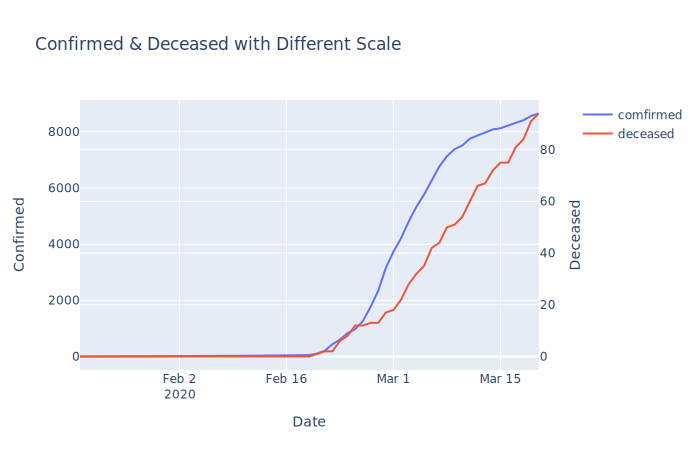

In [3]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=Time.date , y=Time.confirmed, name="comfirmed"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=Time.date, y=Time.deceased, name="deceased"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Confirmed & Deceased with Different Scale"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes
fig.update_layout(
    yaxis=dict(
        title="Confirmed",
    ),
    yaxis2=dict(
        title="Deceased",
    )
)

fig.show()

시간이 지남에 따른 확진자와 사망자의 증가 추세를 살펴보았습니다. 

### 2. TimeProvince

지역별 확진자의 증가추세를 보여줍니다.

In [8]:
fig = px.bar(TimeProvince, x="province", y="confirmed", color="province",
    animation_frame="date", animation_group="province", range_y=[0,5500])
fig.show()

뉴스에서 봤었듯이 대구의 확진자가 가장 많은 것을 알 수가 있었습니다.

다음으로는 지역별 사망자의 증가추세를 보여줍니다.

In [10]:
fig_dec = px.bar(TimeProvince, x="province", y="deceased", color="province",
    animation_frame="date", animation_group="province", range_y=[0,100])
fig_dec.show()

서울은 확진자 수에 비하여 사망자 증가폭이 아주 작은 편이었습니다.

위의 확진자 수에 대한 애니메이션을 시계열 그래프로 나타내면 아래와 같습니다. 

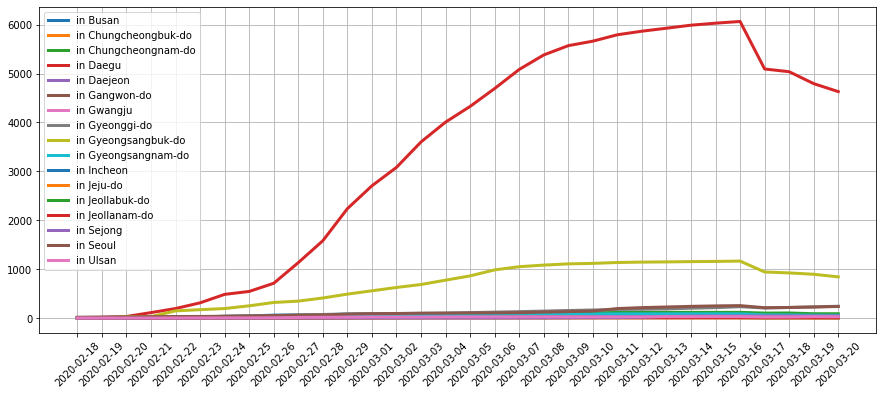

In [11]:
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True

df = TimeProvince.iloc[TimeProvince[TimeProvince.date == "2020-02-18"].index[0]:]

for key, grp in df.groupby(['province']): 
    plt.plot(grp['date'], grp['confirmed']
            ,label = "in {}".format(key)
            )
plt.legend(loc='upper left')    
plt.xticks(rotation=45)

plt.show()

### 3. TimeAge

다음은 연령대에 대한 확진자 수의 증가를 애니메이션으로 나타낸 것입니다.

In [12]:
fig_age = px.bar(TimeAge, x="age", y="confirmed", color="age",
    animation_frame="date", animation_group="age", range_y=[0,3000])
fig_age.show()

다른 나이대에 비하여 20대 확진자 수가 가장 많았습니다.

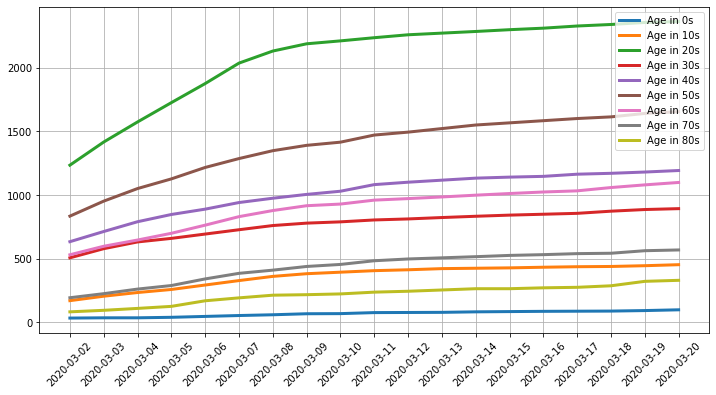

In [13]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True

for key, grp in TimeAge.groupby(['age']): 
    plt.plot(grp['date'], grp['confirmed']
            ,label = "Age in {}".format(key)
            )
plt.legend(loc='upper right')    
plt.xticks(rotation=45)

plt.show()

같은 내용을 시계열 그래프로 나타내보았습니다. 20대 확진자 수는 3월 초에 급격히 증가했음을 확인할 수 있었습니다.

### 4. TimeGender

시간에 따른 성별 확진자 수 증가를 애니메이션으로 나타내었습니다.

In [14]:
fig_sex = px.bar(TimeGender, x="sex", y="confirmed", color="sex",
    animation_frame="date", animation_group="sex", range_y=[0,6000])
fig_sex.show()

여성의 확진자 수가 남성 확진자 수보다 많습니다. 아래에서 같은 내용을 시계열로 나타내보았습니다.

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=TimeGender.date,
                y=TimeGender[TimeGender.sex == "male"].confirmed,
                name="Male",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=TimeGender.date,
                y=TimeGender[TimeGender.sex == "female"].confirmed,
                name="Female",
                line_color='deeppink',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(title_text="Gender; Confirmed")
fig.show()

### 5. SearchTrend

시간에 따른 네 가지 키워드의 검색량을 표현해 보았습니다.

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=SearchTrend.date,
                y=SearchTrend.cold,
                name="Cold",
                line_color='brown',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=SearchTrend.date,
                y=SearchTrend.flu,
                name="Flu",
                line_color='skyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=SearchTrend.date,
                y=SearchTrend.pneumonia,
                name="Pneumonia",
                line_color='green',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=SearchTrend.date,
                y=SearchTrend.coronavirus,
                name="Corona",
                line_color='red',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(title_text="Search Trend")
fig.show()

COVID 19 가 등장한 기간 동안의 검색량을 보면 아래와 같습니다.

In [18]:
fig = go.Figure()

df = SearchTrend.iloc[SearchTrend[SearchTrend.date == "2019-12-19"].index[0]:]

fig.add_trace(go.Scatter(
                x=df.date,
                y=df.cold,
                name="Cold",
                line_color='brown',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df.date,
                y=df.flu,
                name="Flu",
                line_color='skyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df.date,
                y=df.pneumonia,
                name="Pneumonia",
                line_color='green',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df.date,
                y=df.coronavirus,
                name="Corona",
                line_color='red',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(title_text="Search Trend Recent")
fig.show()

2020년 1월 초에 폐렴과 코로나의 검색 트렌드가 유사한 형태를 가지고 있습니다.

### 5-1. Search Trend + Confirmed

아래에서는 Search Trend 를 Confirmed 수와 함께 보았습니다. 아래 그래프는 위 그래프에서 잘 보이지 않던 Pneumonia 와 Flu 의 트렌드를 더 쉽게 보기 위해 스케일링 되어 있음에 유의하시길 바랍니다.

In [19]:
grouped = (Time.groupby(['date'])
            .agg({'confirmed':'sum', 'deceased':'sum'})
            .reset_index())
merged = pd.merge(grouped,SearchTrend,
        how='left',
        on=('date')
        )

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=merged.date , y=merged.confirmed, name="Comfirmed"), secondary_y=False)

fig.add_trace(
    go.Scatter(x=merged.date, y=merged.cold, name="Cold trend"), secondary_y=True)

fig.add_trace(
    go.Scatter(x=merged.date, y=merged.flu, name="Flu trend"), secondary_y=True)

fig.add_trace(
    go.Scatter(x=merged.date, y=merged.pneumonia, name="Pneumonia trend"), secondary_y=True)

# Add figure title
fig.update_layout(
    title_text="Confirmed & Search Trend")

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes
fig.update_layout(
    yaxis=dict(title="Confirmed"),
    yaxis2=dict(title="Trend")
)

fig.show()

확진자 수가 증가하고, 사람들이 COVID-19 에 대하여 알게 되기 시작하면서 폐렴의 검색량이 줄게 되었음을 볼 수 있습니다.

- - -

## Region related

### 1. Region

Region 데이터셋은 크게 Count 와 Ratio 관련 변수로 나누어 살펴보겠습니다.

### 1-1. Count

In [21]:
grouped = (Region[Region.province != "Korea"].groupby(['province'])
            .agg({'elementary_school_count':'sum', 'kindergarten_count':'sum', 'university_count':'sum', 'nursing_home_count':'sum'})
            .reset_index())
    
grouped.iloc[:,1:len(grouped)] = grouped.iloc[:,1:len(grouped)]/2 # Region province별 첫 행이 전체 sum값이 들어있음

import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = grouped.province

# Pie Chart !
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]]
                    ,subplot_titles=["kindergarten", "Elementary", "University", "Nursing Home"])
fig.add_trace(go.Pie(labels=labels, values=grouped.kindergarten_count, name="kindergarten count"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=grouped.elementary_school_count, name="Elementary School count"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=grouped.university_count, name="University count"),
              2, 1)
fig.add_trace(go.Pie(labels=labels, values=grouped.nursing_home_count, name="Nursing Home count"),
              2, 2)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Region Information")
fig.show()

수도권 지역에 관련 시설들이 많이 분포되어있습니다.

### 1-2. Ratio

Academy Ratio를 세부 행정구역별로 표시하였습니다. 명칭이 중복된 행정구의 경우에는 합산되어 나타났지만 시,도 기준으로 색이 구분되어 있습니다.

In [22]:
import plotly.express as px

fig = px.bar(Region, x="city", y="academy_ratio", color='province')
fig.update_layout(
    title='All Academy Ratio'
    , xaxis=dict(
        tickfont_size=14,
        tickangle = 45))
fig.show()

다음으로는 Elderly Ratio 를 행정구역별로 나타내 보았습니다. 명칭이 중복된 행정구의 경우에는 합산되어 나타났습니다.

In [24]:

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(x=Region.city,
                y=Region.elderly_population_ratio,
                name='elderly population ratio'
                # marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=Region.city,
                y=Region.elderly_alone_ratio,
                name='elderly alone ratio',
                marker_color='lightsalmon'
                ))

fig.update_layout(
    title='Elderly Ratio All',
    xaxis=dict(tickfont_size=14, tickangle = 45),
    yaxis=dict(
        title='Ratio (%)',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0.75,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    )
)
fig.show()

확진자 수가 가장 많았던 대구만 그래프를 그려보았습니다.

In [26]:
fig = go.Figure()
fig.add_trace(go.Bar(x=daegu.city,
                y=daegu.elderly_population_ratio,
                name='elderly population ratio'
                # marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=daegu.city,
                y=daegu.elderly_alone_ratio,
                name='elderly alone ratio',
                marker_color='lightsalmon'
                ))

fig.update_layout(
    title='Elderly Ratio in Daegu',
    xaxis=dict(tickfont_size=14, tickangle = 45),
    yaxis=dict(
        title='Ratio (%)',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0.75,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    )
)
fig.show()

### 2. Weather

### 2-1. 대구의 온도 변화와 확진자수 증가 추세의 관계

In [27]:
grouped = (Time.groupby(['date'])
            .agg({'confirmed':'sum', 'deceased':'sum'})
            .reset_index())

daegu_weather = Weather[Weather.province=="Daegu"].reset_index()

merged = pd.merge(grouped,daegu_weather.iloc[:,3:],
        how='left',
        on=('date')
        )

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=merged.date , y=merged.confirmed, name="Comfirmed"), secondary_y=False)

fig.add_trace(
    go.Scatter(x=merged.date, y=merged.avg_temp, name="avg_temp"), secondary_y=True)

fig.add_trace(
    go.Scatter(x=merged.date, y=merged.min_temp, name="min_temp"), secondary_y=True)

fig.add_trace(
    go.Scatter(x=merged.date, y=merged.max_temp, name="max_temp"), secondary_y=True)

# Add figure title
fig.update_layout(
    title_text="Confirmed & Temp")

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes
fig.update_layout(
    yaxis=dict(title="Confirmed"),
    yaxis2=dict(title="temp")
)

fig.show()

### 2-2. 나머지 날씨 변수, 확진자수 증가 추세

기온 변수를 제외한 나머지 날씨 변수들과 확진자 수의 상관관계가 있는지 확인해 보았습니다.

In [28]:
fig = px.scatter_matrix(merged[["confirmed","deceased","precipitation","max_wind_speed","most_wind_direction","avg_relative_humidity"]])
fig.update_layout(
    title='Weather Scatter Matrix')
fig.show()

- - -

## Case + Patient Related

### 1. Patient : 확진자 경로

주어진 PatientRoute 데이터를 지도 위에서 animate해보았습니다.

#### 경로의 색깔 : 확진자가 접촉한 사람 수에 따라서

#### 접촉자 0 명 : 초록색

#### 접촉자 1~10 명 : 파란색

#### 접촉자 11~100명 : 노란색

#### 접촉자 100 초과 : 빨간색

#### 접촉자 수가 최다인 사람 : 검정색

In [29]:
contnum = PatientInfo.iloc[:,[0,12]]
clr = []
for i in range(len(contnum)) :
    if contnum.contact_number[i] == 0 :
        clr.append("green")
    elif contnum.contact_number[i] <= 10 :
        clr.append("blue")
    elif contnum.contact_number[i] <= 100 :
        clr.append("yellow")
    elif contnum.contact_number[i] == max(contnum.contact_number) :
        clr.append("black")
    else : 
        clr.append("red")
contnum["color"] = clr
wcontnum = pd.merge(PatientRoute,contnum,
        how ='left',
        on = 'patient_id').fillna(0)
route_geo = gpd.GeoDataFrame(wcontnum,geometry=gpd.points_from_xy(PatientRoute.longitude,PatientRoute.latitude))

linerange = route_geo[route_geo['patient_id'] == route_geo['patient_id'].shift(1)].index
linerange = linerange.drop(linerange[-1])
lines = [ {
                "coordinates": [
                 [route_geo["longitude"][i] , route_geo["latitude"][i] ],
                 [route_geo["longitude"][i+1] , route_geo["latitude"][i+1],]
                   ],
                "dates": [
                 route_geo["date"][i],
                 route_geo["date"][i+1]
                   ],
                "color": route_geo["color"][i]
                     } for i in linerange ] 
features = [
     {
         'type': 'Feature',
         'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
                },
         'properties': {
            'times': line['dates'],
            'style': {
                'color' : line['color']
            },
            'icon' : 'circle',
            'iconstyle':{
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 3
                }
                }
        }
        for line in lines
    ]


m = folium.Map(
  location=[36.5053542,127.7043419],
  zoom_start=8
)
plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT6H', add_last_point=True).add_to(m)
m.save('with_color.html')
m

### 2. 시간에 따른 infection case 별 확진자 수

In [31]:
inf_case = PatientInfo.infection_case.unique()
for i in range(len(inf_case)) :
    globals()['case'+ str(i)] = PatientInfo[PatientInfo.infection_case == inf_case[i]]
    globals()['case'+str(i)] = pd.DataFrame(globals()['case'+ str(i)].groupby('confirmed_date').count().cumsum().patient_id).reset_index()
    globals()['case'+str(i)].columns = ['confirmed_date','case'+str(i)]   

merged = case0
for i in [x for x in range(len(inf_case)) if x != 0] :
    merged = pd.merge(merged , globals()['case'+str(i)],how= 'outer',on='confirmed_date')
merged = merged.sort_values(by = 'confirmed_date').reset_index()
merged = merged.drop('index',axis=1)
merged.columns = np.insert(inf_case,0,'confirmed_date')
merged = merged.fillna(method='pad')
merged = merged.fillna(0)
merged = merged.set_index('confirmed_date')
fig = merged.iplot(asFigure=True, kind='scatter')
fig.show()

contact with patient 로 인한 확진자 수가 가장 많아 COVID-19 의 높은 전염성을 확인할 수 있었습니다. 다만, 다른 감염원들의 그래프는 시간이 지날 수록 기울기가 완만해지는 형태를 가지고 있는 반면에, overseas inflow 는 3월 중반부터 다시 기울기가 증가하는 형태를 띠기 시작한 것에 주목할 필요가 있습니다.

다음 제출에는 더욱 insight 에 집중하여 분석해보도록 하겠습니다. 감사합니다!